## Import packages and libraries 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import cv2
import math
from numba import jit
from enum import Enum
from skimage import img_as_float, img_as_ubyte
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from sklearn.metrics import mean_squared_error
from PIL import Image

### WTA(winner take all) with different cost functions (SAD,SSD,NCC)

In [2]:
from skimage.io import imread, imsave
from skimage.color import rgb2gray
def readImage(iamgePath):
    rgbImg=cv2.imread(iamgePath)
    grayImg=cv2.cvtColor(rgbImg,cv2.COLOR_BGR2GRAY)
    return grayImg
def readImageT(iamgePath):
    img = imread(iamgePath)
    return rgb2gray(img)

def WTA(cost_volume: np.ndarray) -> np.ndarray:
    return np.argmin(cost_volume, axis=2)

@jit(nopython=True, parallel=True, cache=True)
def NCC(left_image: np.ndarray, right_image: np.ndarray,
            max_disparity: int, filter_radius: int) -> np.ndarray:
    H=left_image.shape[0]
    W = left_image.shape[1]
    cost_volume = np.zeros((max_disparity, H, W))
    for d in range(0, max_disparity):
        for y in range(filter_radius, H - filter_radius):
            for x in range(filter_radius, W - filter_radius):
                l_mean =r_mean =n= 0
                for v in range(-filter_radius, filter_radius + 1):
                    for u in range(-filter_radius, filter_radius + 1):
                        l_mean += left_image[y + v, x + u]
                        r_mean += right_image[y + v, x + u - d]
                        n += 1
                l_mean = l_mean / n
                r_mean = r_mean / n
                l_r = l_var =r_var = 0
                for v in range(-filter_radius, filter_radius + 1):
                    for u in range(-filter_radius, filter_radius + 1):
                        l = left_image[y + v, x + u] - l_mean
                        r = right_image[y + v, x + u - d] - r_mean
                        l_r += l * r
                        l_var += np.power(l,2)
                        r_var += np.power(r,2)
                cost_volume[d, y, x] = -l_r / (np.sqrt(l_var * r_var)+1e-9)
    return np.transpose(cost_volume, (1, 2, 0))

@jit(nopython=True, parallel=True, cache=True)
def SAD(left_image: np.ndarray, right_image: np.ndarray,
            max_disparity: int, filter_radius: int) -> np.ndarray:

    H=left_image.shape[0]
    W = left_image.shape[1]
    cost_volume = np.zeros((H, W, max_disparity))

    # Loop over internal image
    for y in range(filter_radius, H - filter_radius):
        for x in range(filter_radius, W - filter_radius):
            # Loop over window
            for v in range(-filter_radius, filter_radius + 1):
                for u in range(-filter_radius, filter_radius + 1):
                    # Loop over all possible disparities
                    for d in range(0, max_disparity):
                        cost_volume[y, x, d] += np.absolute(
                            left_image[y + v, x + u] -
                            right_image[y + v, x + u - d])

    return cost_volume


@jit(nopython = True, parallel = True, cache = True)
def SSD(left_image: np.ndarray, right_image: np.ndarray, max_disparity: int, filter_radius: int) -> np.ndarray:
    H=left_image.shape[0]
    W = left_image.shape[1]
    cost_volume = np.zeros((H,W,max_disparity))

    # Loop over internal image
    for y in range(filter_radius, H - filter_radius):
        for x in range(filter_radius, W - filter_radius):
            # Loop over window
            for v in range(-filter_radius, filter_radius + 1):
                for u in range(-filter_radius, filter_radius + 1):
                    # Loop over all possible disparities
                    for d in range(0, max_disparity):
                        cost_volume[y,x,d] += (left_image[y+v, x+u] - right_image[y+v, x+u-d])**2

    return cost_volume

def StereoMatchingWTASSD(left_image: np.ndarray,
                 right_image: np.ndarray,
                 max_disparity: int = 60,
                 filter_radius: int = 3) -> np.ndarray:
    cost_volume = SSD(left_image, right_image, max_disparity,filter_radius)
    result = WTA(cost_volume)
    return result

def StereoMatchingWTA(left_image,right_image,matchingCost,max_disparity: int = 60,filter_radius: int = 3) :
    cost_volume = matchingCost(left_image, right_image, max_disparity,filter_radius)
    result = WTA(cost_volume)
    return result

In [3]:
max_disparity = 60 #maximum disparity to consider
filter_radius = 3  #radius of the window t

In [4]:
# import image
left_image = readImageT("../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-left.jpg" )
right_image = readImageT("../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-right.jpg")
groundtruth_image   = readImage("../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-disparity.png")

# pre-set options
max_disparity = 60 #maximum disparity to consider
filter_radius = 3 #radius of the window 

#### calculate and display disparity map with SSD

Text(0.5, 1.0, 'Disparity Image-WTA-SSD')

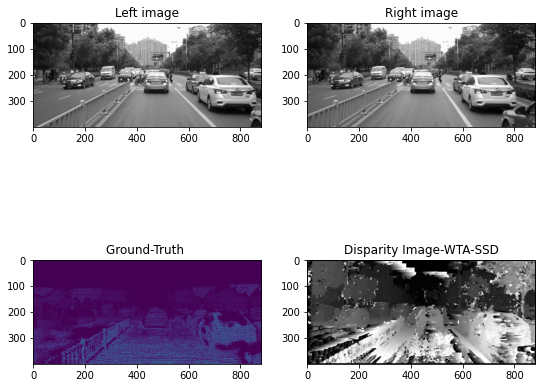

In [5]:
# calculate and display disparity map with SSD

fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(left_image, cmap='gray');
ax1.set_title('Left image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(right_image, cmap='gray');
ax2.set_title('Right image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(groundtruth_image);
ax3.set_title('Ground-Truth ')
ax4 = fig.add_subplot(2,2,4)
#deepth = ((deepth - deepth.min()) / (deepth.max() - deepth.min())*255).astype(np.uint8)
deepth=StereoMatchingWTASSD(left_image,right_image,max_disparity,filter_radius)
ax4.imshow(deepth, cmap='gray' );
ax4.set_title('Disparity Image-WTA-SSD')

#### calculate and display disparity map with NCC

Text(0.5, 1.0, 'Disparity Image-WTA-NCC')

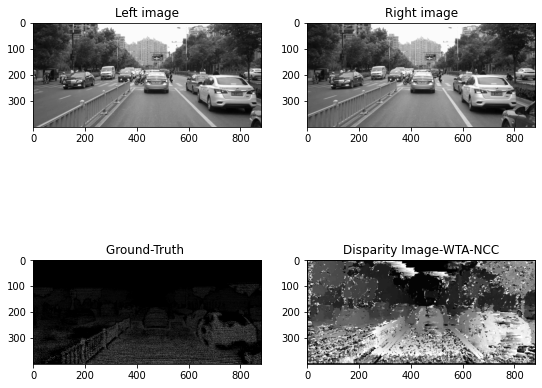

In [6]:
# calculate and display disparity map with NCC

fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(left_image, cmap='gray');
ax1.set_title('Left image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(right_image, cmap='gray');
ax2.set_title('Right image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(groundtruth_image, cmap='gray');
ax3.set_title('Ground-Truth ')
ax4 = fig.add_subplot(2,2,4)
#deepth = ((deepth - deepth.min()) / (deepth.max() - deepth.min())*255).astype(np.uint8)
deepth=StereoMatchingWTA(left_image,right_image,NCC,max_disparity,filter_radius)
ax4.imshow(deepth, cmap='gray');
ax4.set_title('Disparity Image-WTA-NCC')

#### calculate and display disparity map with SAD

Text(0.5, 1.0, 'Disparity Image-WTA-SAD')

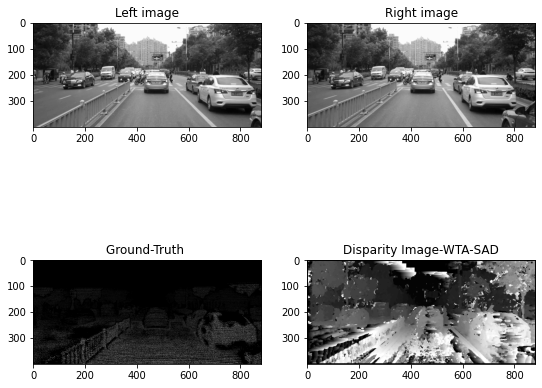

In [7]:
# calculate and display disparity map with SAD
fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(left_image, cmap='gray');
ax1.set_title('Left image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(right_image, cmap='gray');
ax2.set_title('Right image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(groundtruth_image, cmap='gray');
ax3.set_title('Ground-Truth ')
ax4 = fig.add_subplot(2,2,4)
#deepth = ((deepth - deepth.min()) / (deepth.max() - deepth.min())*255).astype(np.uint8)
deepth=StereoMatchingWTA(left_image,right_image,SAD,max_disparity,filter_radius)
ax4.imshow(deepth, cmap='gray');
ax4.set_title('Disparity Image-WTA-SAD')


(array([56856., 61706., 49460., 33234., 25779., 32011., 18340., 19620.,
        23186., 32208.]),
 array([ 0. ,  5.9, 11.8, 17.7, 23.6, 29.5, 35.4, 41.3, 47.2, 53.1, 59. ]),
 <BarContainer object of 10 artists>)

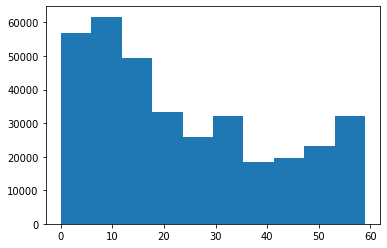

In [8]:
plt.hist(deepth.reshape(-1))

In [9]:
def getRSME(prediction_image,groundTruth):
    return np.sqrt(mean_squared_error(prediction_image, groundTruth))

def getFractions(prediction_image,groundtruth_image,threshold_disparity=4):
    mask_image = np.ones(prediction_image.shape)

    number_of_pixels = mask_image.sum() 
    weighted_image = mask_image * (np.absolute(
        prediction_image - groundtruth_image) <= threshold_disparity)
    return np.sum(weighted_image)/ number_of_pixels 

In [10]:
imageList=[]
for dirname, _, filenames in os.walk('../input/stereodisparity'):
    for filename in filenames:
        if os.path.join(dirname, filename).split('-')[-1]=='left.jpg':
            imageList.append(os.path.join(dirname, filename))


In [11]:
start_time = time.time()
for leftPath in imageList:
    rightPath=leftPath[:-8]+'right.jpg'
    groundTruthPath=leftPath[:-8]+'disparity.png'
    left_image = readImageT(leftPath)
    right_image = readImageT(rightPath)
    groundtruth_image  = readImage(groundTruthPath)
    #groundtruth_image=cv2.imread(groundTruthPath,cv2.CV_16UC1)
    
    deepth=StereoMatchingWTASSD(left_image,right_image,max_disparity,filter_radius)
    
    print(leftPath)
    print('RSME:',getRSME(deepth,groundtruth_image))
    for threshold_disparity in [4, 2, 1, 0.5,0.25]:
        f=getFractions(deepth,groundtruth_image,threshold_disparity)*100
        print(f'fractions of {threshold_disparity} is : {f} %',)
end_time = time.time()
print("Time consume: {:.2f}s".format(end_time - start_time))
print("Average pair time consume: {:.2f}s".format((end_time - start_time)/len(imageList)))


../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-40-37-947-left.jpg
RSME: 23.333903383393913
fractions of 4 is : 36.5522133938706 %
fractions of 2 is : 30.23382519863791 %
fractions of 1 is : 25.22758229284904 %
fractions of 0.5 is : 14.438138479001136 %
fractions of 0.25 is : 14.438138479001136 %
../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-46-01-859-left.jpg
RSME: 24.20418803640607
fractions of 4 is : 29.17395005675369 %
fractions of 2 is : 24.46140749148695 %
fractions of 1 is : 17.84790011350738 %
fractions of 0.5 is : 9.594494892167992 %
fractions of 0.25 is : 9.594494892167992 %
../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-38-52-780-left.jpg
RSME: 25.179404239246008
fractions of 4 is : 30.05079455164586 %
fractions of 2 is : 25.08371169125993 %
fractions of 1 is : 19.24233825198638 %
fractions of 0.5 is : 11.727298524404087 %
fractions of 0.25 is : 11.727298524404087 %
../input/stereodisparity/Dataset/2018-07-09-16-11-

#### improve with median filter

Text(0.5, 1.0, 'Disparity Image-WTA-SSD-Smooth')

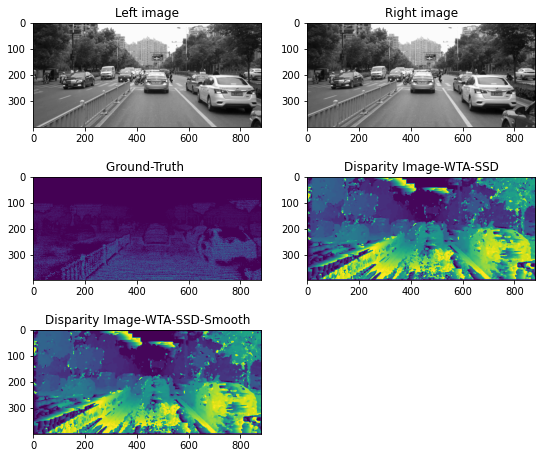

In [12]:
# read the raw image again

left_image = readImageT("../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-left.jpg" )
right_image = readImageT("../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-right.jpg")
groundtruth_image   = readImage("../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-disparity.png")


#calculate and display the disparity map with SSD and median filter
fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(3,2,1)
ax1.imshow(left_image, cmap='gray');
ax1.set_title('Left image')
ax2 = fig.add_subplot(3,2,2)
ax2.imshow(right_image, cmap='gray');
ax2.set_title('Right image')
ax3 = fig.add_subplot(3,2,3)
ax3.imshow(groundtruth_image);
ax3.set_title('Ground-Truth ')
ax4 = fig.add_subplot(3,2,4)
#deepth = ((deepth - deepth.min()) / (deepth.max() - deepth.min())*255).astype(np.uint8)
deepth=StereoMatchingWTASSD(left_image,right_image,max_disparity,filter_radius)
ax4.imshow(deepth);
ax4.set_title('Disparity Image-WTA-SSD')
ax5 = fig.add_subplot(3,2,5)
deepthSmooth=cv2.medianBlur(np.uint8(deepth),3)
ax5.imshow(deepthSmooth);
ax5.set_title('Disparity Image-WTA-SSD-Smooth')

#### use jit to accelerate the process

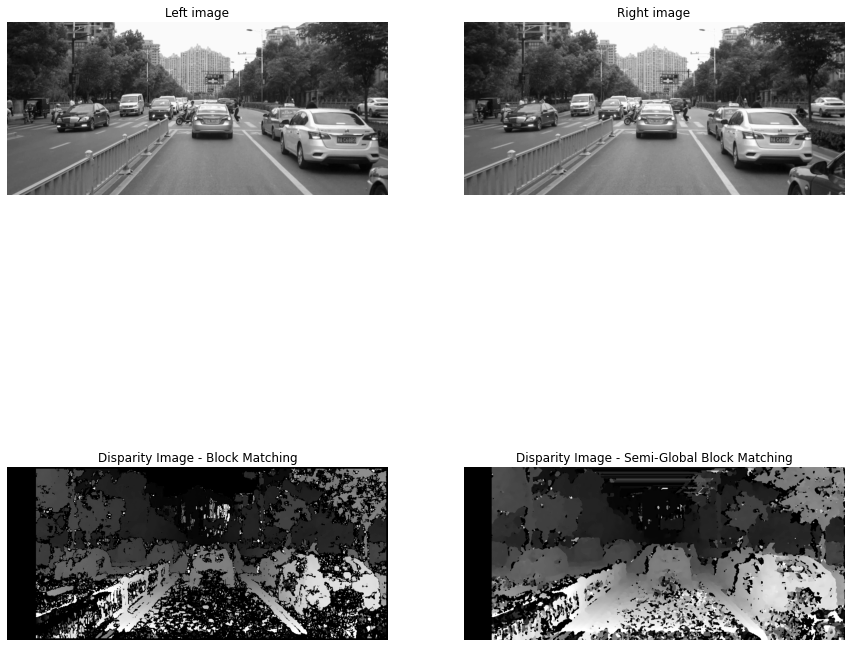

In [13]:
# Read in images from a filepath as graycsale
imgL = readImage("../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-left.jpg" )
imgR= readImage("../input/stereodisparity/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-right.jpg")
# Computing stereo correspondence using the block matching algorithm.
# Initialize the stereo block matching object 
''' 
numDisparities - the disparity search range. For each pixel algorithm will find 
                the best disparity from 0 (default minimum disparity) to numDisparities. 
                The search range can then be shifted by changing the minimum disparity.
blockSize - the linear size of the blocks compared by the algorithm. 
                The size should be odd (as the block is centered at the current pixel). 
                Larger block size implies smoother, though less accurate disparity map. 
                Smaller block size gives more detailed disparity map, 
                but there is higher chance for algorithm to find a wrong correspondence. 
'''
num_disp = 64 # try to tune the parameters to get better&smooth result
block_size = 9
stereoBM = cv2.StereoBM_create(numDisparities=num_disp,
                             blockSize=block_size)

# Compute the disparity image
disparityBM = stereoBM.compute(imgL,imgR)

# Scale the pixel values to between 0-255 (Or you can normalized to [0,1])
Min = disparityBM.min()
Max = disparityBM.max()
disparityBM = ((disparityBM - Min) / (Max - Min)*255).astype(np.uint8)

# Computing stereo correspondence using the semi-global block matching algorithm.
# This method uses block matching with additional constraints (disparity smoothness)
# Initialize the stereo block matching object 
stereoSGBM = cv2.StereoSGBM_create(numDisparities=num_disp,
                             blockSize=block_size)

# Compute the disparity image
disparitySGBM = stereoSGBM.compute(imgL,imgR)

# Scale the pixel values to between 0-255 (Or you can normalized to [0,1])
Min = disparitySGBM.min()
Max = disparitySGBM.max()
disparitySGBM = ((disparitySGBM - Min) / (Max - Min)*255).astype(np.uint8)

# Display the result
plt.subplots(figsize=(15, 15)) 

plt.subplot(2,2,1)
plt.imshow(imgL, cmap='gray')  
plt.title('Left image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(imgR, cmap='gray')  
plt.title('Right image')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(disparityBM,'gray')
plt.title('Disparity Image - Block Matching')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(disparitySGBM,'gray')
plt.title('Disparity Image - Semi-Global Block Matching')
plt.axis('off')

plt.show()

### SGM (semi global matching)

In [14]:
class SGMOptions:
    def __init__(self):
        self.min_disparity = 2      #minimum disparity
        self.max_disparity = 64     #maximum disparity
        self.p1 = 5                 #param 1 for penalty
        self.p2 = 150               #param 2 for penalty
        self.unique_ratio = 0.98    #uniqueness thredshold (1 if do not apply uniqueness check)

In [15]:
class SGMUtils:
    def __init__(self):
        self.Invalid_float = float('inf')
    
    def CensusTransform_5x5(self, source, census, width, height):
        """
        traverse the neighbour pixels within a 5x5 window, compare the neighbour pixel value 
        with the center pixel value, calculate the census value.

        :param source: the source image
        :param census: the census array stores the censsu value of each pixel
        :param width:  the width of the source
        :param height: the height of the source
        :return: None
        
        """ 
        for i in range(2, height-2):
            for j in range(2, width-2):
                gray_center = int(source[i*width+j])
                census_val = 0
                for r in range(-2, 3):
                    for c in range(-2,3):
                        census_val<<=1
                        gray = int(source[(i+r)*width +j+c])
                        if(gray<gray_center):
                            census_val +=1
                census[i*width+j] = census_val
                
    
    def HammingDistance(self, x, y):
        """
        calculate the Hamming distance between two value x,y

        :param x: the x value
        :param y: the y value
        :return: None
        
        """ 
        dist = 0
        for i in range(31,-1,-1):
            b1= x>>i&1
            b2 = y>>i&1
            dist+= not(b1==b2)
        return dist
    
    def CostAggregateLeftRight(self, img_data, width, height, min_disp, max_disp, p1, p2, cost_init, cost_aggr, is_forward):
        """
        loop through each pixels row by row.
        for each pixel get cost from its left pixels and right pixels and aggregate them.

        :param img_data: the image array -- get flattened so is a 1D array
        :param width: the width of the image
        :param height: the height of the image
        :param min_disp: minimum disparity
        :param max_disp: maximum disparity
        :param p1: penalty parameter
        :param p2: penalty parameter
        :param cost_init: array that stores the initial cost
        :param cost_aggr: array that stores the aggregated cost
        :param is_forward: traverse direction
        :return: None
        
        """ 
        disp_range = max_disp-min_disp
        
        # (left->right) ：is_forward = true ; direction = 1
        # (right->left) ：is_forward = false; direction = -1;
        if(is_forward):
            direction = 1
        else:
            direction = -1
        
        # aggregation
        for i in range(0, height):
            # the row head is the first(last if is_forward==false) coloumn pixel of the row
            if(is_forward):
                cost_init_row_head = i * width * disp_range
                cost_aggr_row_head = i * width * disp_range
                img_row = img_data[i * width]
            else:

                cost_init_row_head = i * width * disp_range + (width - 1) * disp_range
                cost_aggr_row_head = i * width * disp_range + (width - 1) * disp_range
                img_row = img_data[i * width + width - 1]
                
            # current gray value and last gray value
            gray = int(img_row);
            gray_last = int(img_row);
                
            # the cost array of last pixel on the row
            cost_last_path = [sys.maxsize]*(disp_range+2)
            
            # initialize: the aggregated cost of first pixel is same as its initial cost
            cost_aggr[cost_aggr_row_head:cost_aggr_row_head+disp_range] = cost_init[cost_init_row_head:
                                                                                cost_init_row_head + disp_range]
            cost_last_path[1:1+disp_range] = cost_aggr[cost_aggr_row_head:cost_aggr_row_head+disp_range]

            cost_init_row_head += direction * disp_range
            cost_aggr_row_head += direction * disp_range
            img_row = img_data[i * width + direction] if is_forward else img_data[i * width + width - 1 + direction]
            
            # the minimum cost of last pixel on the row
            mincost_last_path = sys.maxsize
            for cost in cost_last_path:
                mincost_last_path = min(mincost_last_path, cost)
            
            # aggregation start from second pixel 
            for j in range(0, width-1):
                gray = img_row
                min_cost = sys.maxsize
                for d in range(0, disp_range):
                    #Lr(p,d) = C(p,d) + min( Lr(p-r,d), Lr(p-r,d-1) + P1, Lr(p-r,d+1) + P1, min(Lr(p-r))+P2 ) - min(Lr(p-r)      
                    cost = int(cost_init[cost_init_row_head + d])
                    l1 = cost_last_path[d+1]
                    l2 = cost_last_path[d] + p1
                    l3 = cost_last_path[d+2] + p1
                    l4 = mincost_last_path + max(p1, p2/(abs(gray - gray_last) + 1))
                
                    cost_s = cost + abs(int(min( min(l1, l2), min(l3, l4)) - mincost_last_path ));
                    cost_aggr[cost_aggr_row_head + d] = cost_s;
                    min_cost = min(min_cost, cost_s);
                
                # reset the min cost and cost array of last pixel
                mincost_last_path = min_cost
                cost_last_path[1:1+disp_range] = cost_aggr[cost_aggr_row_head:cost_aggr_row_head+disp_range]
                
                # next pixel
                cost_init_row_head += direction * disp_range
                cost_aggr_row_head += direction * disp_range
                img_row = img_data[i * width + direction] if is_forward else img_data[i * width + width - 1 + direction]
                
                # reset the gray value
                gray_last = gray;
                
    def CostAggregateUpDown(self, img_data, width, height, min_disp, max_disp, p1, p2, cost_init, cost_aggr, is_forward):
        """
        loop through each pixels column by column.
        for each pixel get cost from its upside pixels and downside pixels and aggregate them.

        :param img_data: the image array -- get flattened so is a 1D array
        :param width: the width of the image
        :param height: the height of the image
        :param min_disp: minimum disparity
        :param max_disp: maximum disparity
        :param p1: penalty parameter
        :param p2: penalty parameter
        :param cost_init: array that stores the initial cost
        :param cost_aggr: array that stores the aggregated cost
        :param is_forward: traverse direction
        :return: None
        
        """ 
        disp_range = max_disp-min_disp
        
        # (upside->downside) ：is_forward = true ; direction = 1
        # (downside->upside) ：is_forward = false; direction = -1;
        if(is_forward):
            direction = 1
        else:
            direction = -1
        
        # aggregation
        for j in range(0, width):
            
            if(is_forward):
                cost_init_col_head = j * disp_range
                cost_aggr_col_head = j * disp_range
                img_col = img_data[j]
            else:
                cost_init_col_head = (height-1)*width*disp_range + j * disp_range
                cost_aggr_col_head = (height-1)*width*disp_range + j * disp_range
                img_col = img_data[(height-1)*width +j]
                
            gray = img_col;
            gray_last = img_col;
                
            cost_last_path = [sys.maxsize]*(disp_range+2)
            

            cost_aggr[cost_aggr_col_head:cost_aggr_col_head+disp_range] = cost_init[cost_init_col_head:
                                                                                    cost_init_col_head + disp_range]
            cost_last_path[1:1+disp_range] = cost_aggr[cost_aggr_col_head:cost_aggr_col_head+disp_range]


            cost_init_col_head += direction*width*disp_range
            cost_aggr_col_head += direction*width*disp_range
            img_col += direction*width
            
            
            mincost_last_path = sys.maxsize
            for cost in cost_last_path:
                mincost_last_path = min(mincost_last_path, cost)
            
            for i in range(0, height-1):
                gray = img_col
                min_cost = sys.maxsize
                for d in range(0, disp_range):
                    #Lr(p,d) = C(p,d) + min( Lr(p-r,d), Lr(p-r,d-1) + P1, Lr(p-r,d+1) + P1, min(Lr(p-r))+P2 ) - min(Lr(p-r)      
                    cost = abs(int(cost_init[cost_init_col_head + d]))
                    l1 = cost_last_path[d+1]
                    l2 = cost_last_path[d] + p1
                    l3 = cost_last_path[d+2] + p1
                    l4 = mincost_last_path + max(p1, p2/(abs(gray - gray_last) + 1))
                
                    cost_s = cost + abs(int(min(min(l1, l2), min(l3, l4)) - mincost_last_path));
                    cost_aggr[cost_aggr_col_head + d] = cost_s;
                    min_cost = min(min_cost, cost_s);

                mincost_last_path = min_cost
                cost_last_path[1:1+disp_range] = cost_aggr[cost_aggr_col_head:cost_aggr_col_head+disp_range]
                
                cost_init_col_head += direction*width*disp_range
                cost_aggr_col_head += direction*width*disp_range
                img_col += direction*width
                
                gray_last = gray;



In [16]:
class SemiGlobalMatching:
    
    def __init__(self, img_l, img_r):
        self.img_left_ = img_l
        self.img_right_ = img_r
        self.options_ = SGMOptions()
        self.utils_ = SGMUtils()
    
    def Initialize(self, width, height):
        """
        Initialize some global variables

        :param width:    the height of the image
        :param height:   the width of the image
        :return: None
        
        """ 
        self.width_ = width
        self.height_ = height
        
        #cencus value
        self.census_left_ = [0]*width*height
        self.census_right_ = [0]*width*height
        
        #match cost
        self.disp_range_ = options.max_disparity-options.min_disparity
        self.cost_init_ = [0]*width*height*self.disp_range_
        self.cost_aggr_ = [0]*width*height*self.disp_range_
        
        #disparity map
        self.disp_left_ = [0.0]*width*height
        self.disp_right_ = [0.0]*width*height
        
        self.size = self.width_*self.height_*self.disp_range_
        
        #aggregation
        self.cost_aggr_1 = [0]*self.size
        self.cost_aggr_2 = [0]*self.size
        self.cost_aggr_3 = [0]*self.size
        self.cost_aggr_4 = [0]*self.size
        
        #refinement
        self.occlusions_ = []
        self.mismatches_ = []
    
    def CensusTransform(self):
        """
        calculate the census value of left image and right image,
        store in self.census_left_ and self.census_right_

        :return: None
        
        """ 
        self.utils_.CensusTransform_5x5(self.img_left_, self.census_left_, 
                                        self.width_,self.height_)
        self.utils_.CensusTransform_5x5(self.img_right_, self.census_right_, 
                                        self.width_,self.height_)
    
    #计算代价（基于Hamming距离）
    def ComputeCost(self):
        """
        compute the matching cost based on hamming distance,
        the cost values store in self.cost_init_

        :return: None
        
        """ 
        min_disp = self.options_.min_disparity
        max_disp = self.options_.max_disparity
        
        width = self.width_
        height = self.height_
        for i in range(0, height):
            for j in range(0, width):
                
                for d in range(min_disp, max_disp):
                    
                    if(j-d<0 or j-d>=width):
                        self.cost_init_[i*width*self.disp_range_ + 
                                        j*self.disp_range_ + (d-min_disp)] = sys.maxsize
                        continue
                        
                    # census value of left img
                    census_val_left = abs(int(self.census_left_[i*width + j]))       
                      
                    # census value of correlated point in right img      
                    census_val_right = abs(int(self.census_right_[i*width + j-d]))
                    
                    # compute cost
                    cost = self.utils_.HammingDistance(census_val_left, census_val_right)
                    self.cost_init_[i* width* self.disp_range_+ 
                                    j* self.disp_range_+ (d-min_disp)] = cost
                    
    def CostAggregation(self):
        """
        compute the aggregated matching cost based on neighbour pixels,
        the aggregated cost values store in cost_aggr_
        
           ↓      3  
         →   ←  1   2
           ↑      4  

        :return: None
        
        """ 
        
        min_disp = self.options_.min_disparity
        max_disp = self.options_.max_disparity
        p1 = self.options_.p1
        p2 = self.options_.p2
        width = self.width_
        height = self.height_
        img_data = self.img_left_
        
        # left-right
        self.utils_.CostAggregateLeftRight(img_data, width, height,min_disp, max_disp, p1, p2, 
                                           self.cost_init_, self.cost_aggr_1, True)
        self.utils_.CostAggregateLeftRight(img_data, width, height,min_disp, max_disp, p1, p2, 
                                           self.cost_init_, self.cost_aggr_2, False)
        # up-down
        self.utils_.CostAggregateUpDown(img_data, width, height, min_disp, max_disp, p1, p2, 
                                            self.cost_init_, self.cost_aggr_3, True)
        self.utils_.CostAggregateUpDown(img_data, width, height, min_disp, max_disp, p1, p2, 
                                            self.cost_init_, self.cost_aggr_4, False)
        
        for i in range(0, self.size):
            self.cost_aggr_[i] = self.cost_aggr_1[i]+self.cost_aggr_2[i]+self.cost_aggr_3[i]+self.cost_aggr_4[i]

    def ComputeDisparity(self):
        """
        compute the disparity with subpixel and uniqueness check

        :return: None
        
        """ 
        min_disp = self.options_.min_disparity
        max_disp = self.options_.max_disparity
        
        width = self.width_
        height = self.height_
        
        cost_ptr = self.cost_aggr_
        
        #create a temp array to store all the cost value of one pixel
        cost_local = [sys.maxsize]*self.disp_range_
        
        # calculate the best disparity pixel by pixel
        for i in range(0, height):
            for j in range(0, width):
                min_cost = sys.maxsize
                sec_min_cost = sys.maxsize #second minimum cost
                best_disparity = 0
                
                # traverse all the cost value within disparity range and
                # output the minimum cost as well as the related disparity
                for d in range(min_disp, max_disp):
                    d_idx = d - min_disp
                    cost = cost_ptr[i*width*self.disp_range_ +j*self.disp_range_ + d_idx]
                    cost_local[d_idx] = cost
                    if(min_cost>cost):
                        min_cost = cost
                        best_disparity = d
                
                # traverse again to find the second minimum cost
                for d in range(min_disp, max_disp):
                    if(d==best_disparity):
                        continue
                    cost = cost_local[d-min_disp]
                    sec_min_cost = min(sec_min_cost, cost)
                    
                # uniqueness check
                if(sec_min_cost-min_cost<=abs(int(min_cost*(1-self.options_.unique_ratio)))):
                    self.disp_left_[i*width+j] = self.utils_.Invalid_float
                    continue
                    
                # Subpixel
                # instead using the disparity directly, calculate the curve construct by the costs of 
                # its neibour pixels and apply the disparity of subpixel--Extreme point of that curve.
                if(best_disparity==min_disp or best_disparity==max_disp-1):
                    self.disp_left_[i*width +j] = self.utils_.Invalid_float
                else:
                    idx_1 = best_disparity-1 - min_disp
                    idx_2 = best_disparity+1 - min_disp
                    cost_1 = cost_local[idx_1]
                    cost_2 = cost_local[idx_2]
                    denom = max(1, cost_1+cost_2 - 2*min_cost)
                    self.disp_left_[i*width + j] = float(best_disparity) + float((cost_1-cost_2)/denom*2.0)

    
    def ComputeDisparityRight(self):
        """
        compute the disparity of right image with subpixel and uniqueness check

        :return: None
        
        """ 
        min_disp = self.options_.min_disparity
        max_disp = self.options_.max_disparity
        
        cost_ptr = self.cost_aggr_
        
        cost_local = [sys.maxsize]*self.disp_range_
        
        for i in range(0,self.height_):
            for j in  range(0,self.width_):
                min_cost = sys.maxsize
                sec_min_cost = sys.maxsize #second minimum cost
                best_disparity = 0
                
                for d in range(min_disp, max_disp):
                    d_idx = d - min_disp
                    col_left = j+d
                    if(col_left>=0 and col_left<width):
                        cost = self.cost_aggr_[i*width*self.disp_range_+
                                         col_left*self.disp_range_+d_idx]
                        if(min_cost>cost):
                            min_cost=cost
                            best_disparity = d
                        
                    else:
                        cost_local[d_idx] = sys.maxsize
                
                for d in range(min_disp, max_disp):
                    if(d==best_disparity):
                        continue
                    cost = cost_local[d-min_disp]
                    sec_min_cost = min(sec_min_cost, cost)
                    
                if(sec_min_cost-min_cost<=abs(int(min_cost*(1-self.options_.unique_ratio)))):
                    self.disp_right_[i*width+j] = self.utils_.Invalid_float
                    continue

                if(best_disparity==min_disp or best_disparity==max_disp-1):
                    self.disp_left_[i*self.width_ +j] = self.utils_.Invalid_float
                else:
                    idx_1 = best_disparity-1 - min_disp
                    idx_2 = best_disparity+1 - min_disp
                    cost_1 = cost_local[idx_1]
                    cost_2 = cost_local[idx_2]
                    denom = max(1, cost_1+cost_2 - 2*min_cost)
                    self.disp_right_[i*self.width_ + j] = float(best_disparity) + float((cost_1-cost_2)/denom*2.0)
                    
    def ConsistencyCheck(self):
        """
        Consistency Check.
        Basically done by swap the left image and right image then calculate the disparity again and for each pixel A in left 
        image disparity map, find the same pixel B in right image disparity map and check if the disparity difference 
        is under certain threshold.

        :return: None
        
        """ 
        width = self.width_
        height = self.height_
        
        threshold = 1.0
        occlusions = self.occlusions_
        mismatches = self.mismatches_
        occlusions.clear()
        mismatches.clear()
        
        for i in range(0,height):
            for j in range(0,width):
                disp = self.disp_left_[i*width+j]
                if(disp==self.utils_.Invalid_float):
                    mismatches.append([i,j])
                    continue
                    
                # find the same pixel in right image based on disparity
                col_right = int(j-disp+0.5)
                if(col_right>=0 and col_right<width):
                    disp_r = self.disp_right_[i*width+col_right]
                    # check if two disparity value are within the threshold
                    if(abs(disp-disp_r)>threshold):
                        col_rl = int(col_right+disp_r+0.5)
                        if(col_rl>0 and col_rl<width):
                            disp_l = self.disp_left_[i*width+col_rl]
                            if(disp_l>disp):
                                occlusions.append([i,j])
                            else:
                                mismatches.append([i,j])
                        else:
                            mismatches.append([i,j])
                        disp = self.utils_.Invalid_float
                else:
                    disp = self.utils_.Invalid_float
                    mismatches.append([i,j])
        
        
    def Match(self, img_left, img_right, disp_left_):
        """
        the entry point of the SGM method
        
        :param img_left:    the left image
        :param img_right:   the right image
        :param disp_left_:   the disparity of left image
        :return: None
        
        """ 
        self.img_left_ = img_left
        self.img_right_ = img_right
        self.disp_left_ = disp_left_
        
        self.CensusTransform()
        
        self.ComputeCost()
        
        self.CostAggregation()
        
        print("CostAggregation Done")
        
        self.ComputeDisparity() 
        
        print("ComputeDisparity Done")   
        
        self.ComputeDisparityRight()
        
        print("ComputeDisparityRight Done")  
        
        self.ConsistencyCheck()
        
        print("ConsistencyCheck Done")
        

        cvImg = np.zeros((self.height_, self.width_), dtype = "uint8")
        min_disp = float(self.width_)
        max_disp = float(-self.width_)
        for i in range(0, self.height_):
            for j in range(0, self.width_):
                disp = self.disp_left_[i*width +j]
                if(disp != self.utils_.Invalid_float):
                    min_disp = float(min(disp, min_disp))
                    max_disp = float(min(disp, max_disp))
        for i in range(0, self.height_):
            for j in range(0, self.width_):
                disp = self.disp_left_[i*width +j]
                if(disp==self.utils_.Invalid_float):
                    cvImg[i][j] = 0
                else:
                    cvImg[i][j] = abs(int((disp-min_disp)/(max_disp-min_disp)*255))
                    
        #cvImg = cv2.medianBlur(cvImg, 3)
        return cvImg
                    

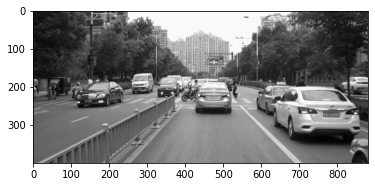

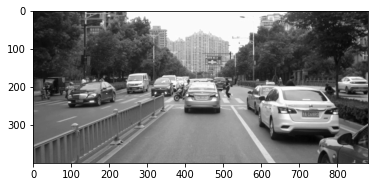

In [18]:
os.chdir(r'../input/stereodisparity/Dataset')
lraw=np.asanyarray(Image.open(r"2018-07-09-16-11-56_2018-07-09-16-55-15-689-left.jpg"))
rraw=np.asanyarray(Image.open(r"2018-07-09-16-11-56_2018-07-09-16-55-15-689-right.jpg"))


gt_raw = np.asanyarray(Image.open(r"2018-07-09-16-11-56_2018-07-09-16-55-15-689-disparity.png"))

img_left= cv2.cvtColor(lraw,cv2.COLOR_BGR2GRAY)
img_right= cv2.cvtColor(rraw,cv2.COLOR_BGR2GRAY)
img_left=np.asanyarray(img_left,dtype=np.float32)
img_right=np.asanyarray(img_right,dtype=np.float32)

gt_img = gt_raw
#gt_img = np.asanyarray(gt_raw,dtype=np.float32)

img_size=np.shape(img_left)[0:2]
plt.imshow(img_left, cmap="gray")
plt.show()
plt.imshow(img_right, cmap="gray")
plt.show()

In [19]:
height = img_left.shape[0]
width = img_left.shape[1]
print("height:"+str(height)+" width:"+str(width))

height:400 width:881


In [22]:
options = SGMOptions()
SGM = SemiGlobalMatching(img_left.flatten(), img_right.flatten())

In [23]:
SGM.Initialize(width,height)

In [25]:
disparity = [float(0)]*width*height

In [26]:
tic1=time.time()
disp_map = SGM.Match(img_left.flatten(), img_right.flatten(), disparity)
print('Time consume:',time.time()-tic1, "s")

CostAggregation Done
ComputeDisparity Done
ComputeDisparityRight Done
ConsistencyCheck Done
Time consume: 606.6268908977509 s


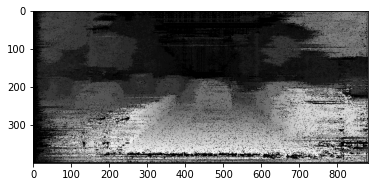

In [27]:
#disp_map = np.asarray(SGM.disp_left_).reshape(height,width)
plt.imshow(disp_map, cmap="gray")
plt.show()

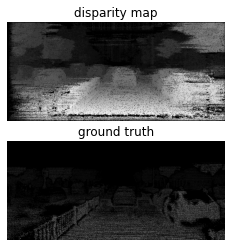

In [28]:
plt.subplot(2,1,1)
plt.imshow(disp_map, cmap='gray')  
plt.title('disparity map')
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(gt_img, cmap='gray')  
plt.title('ground truth')
plt.axis('off')

plt.show() 

In [29]:
SGMerr = getRSME(disp_map,gt_img)
SGMerr

4861.468328411093

In [31]:
for threshold_disparity in [4, 2, 1, 0.5,0.25]:
    f=getFractions(disp_map,gt_img,threshold_disparity)*100
    print(f'fractions of {threshold_disparity} is : {f} %',)

fractions of 4 is : 46.00482406356413 %
fractions of 2 is : 34.59137343927355 %
fractions of 1 is : 27.982406356413165 %
fractions of 0.5 is : 17.88365493757094 %
fractions of 0.25 is : 17.88365493757094 %
